In [13]:

import csv
import urllib.request as urllib2
import time

# !pip install urllib2 
# import urllib2 

start_time = time.time()

import pandas as pd
 
url = 'https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv'
response = urllib2.urlopen(url)

df_d = pd.read_csv(response)
df_d = df_d.dropna()

# Ques-1
# Solution-1
df_d.head(10) 
# First 10 records will be displayed.

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


In [0]:
# Que-2 output is being displayed
# line graph is plotted 

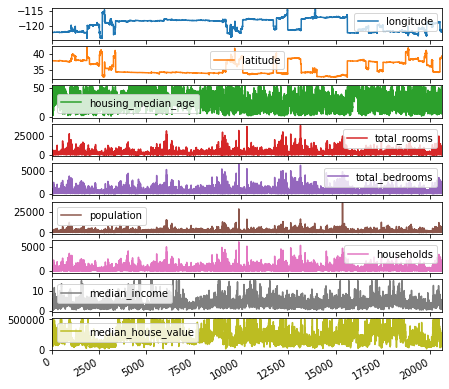

In [15]:
df_d.plot(subplots=True, figsize=(7, 7));

In [0]:
import torch
from torch.nn import Conv1d
from torch.nn import Dropout

from torch.nn import MaxPool1d
from torch.nn import AvgPool1d


from torch.nn import  Flatten

from torch.nn import Linear

from torch.nn.functional import relu

from torch.utils.data import DataLoader, TensorDataset

In [0]:
# Subclass is defined
class CnnRegressor(torch.nn.Module):
  def __init__(self, batch_size, inputs, outputs):
    
    # The superclass is initialized and the parameters are stored
    super(CnnRegressor, self).__init__()
    self.batch_size = batch_size
    self.inputs = inputs
    self.outputs = outputs
    
    
    # Each and every layer is defined

    self.input_layer  = Conv1d(inputs, batch_size, 1)
    # Input layer is defined in which input channels, output channels, kernel size are considered.

    self.max_pooling_layer = MaxPool1d(1) 
    # MaxPooling layer converts the negative values to zero and positive values are remained same.
    # (kernel size)
    
    self.conv_layer = Conv1d(batch_size, 256,1) #Conv1D

    self.flatten_layer = Flatten()

    self.linear_layer = Linear(256, 64)

    self.output_layer = Linear(64, outputs)

  # method to obtain the inputs for the model

  def feed(self,input):
    input = input.reshape((self.batch_size, self.inputs, 1))
    
    output = relu(self.input_layer(input))

    output = self.max_pooling_layer(output)

    output = relu(self.conv_layer(output))
     
    output = self.flatten_layer(output)
    
    output = self.linear_layer(output)

    output = self.output_layer(output)

    return output

In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split
    
import numpy as np

In [19]:
# Based on remaining columns median house value are predicted
df_d_x = df_d.loc[:,'longitude':'median_income']
df_d_y = df_d['median_house_value']


X_train, X_test, y_train, y_test = train_test_split(df_d_x, df_d_y, test_size=0.3, random_state=2003)
# For training and testing the datasets are splitted

# The testing datasets are converted to numpy array
x_test_np = X_test.to_numpy()
y_test_np = y_test.to_numpy()

# The training datasets are converted to numpy array
x_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()

print(x_train_np.shape, y_train_np.shape, x_test_np.shape, y_test_np.shape)

(14303, 8) (14303,) (6130, 8) (6130,)


In [20]:
batch_size = 64
# batch size is defined

model = CnnRegressor(batch_size, df_d_x.shape[1],1)

model.cuda()

CnnRegressor(
  (input_layer): Conv1d(8, 64, kernel_size=(1,), stride=(1,))
  (max_pooling_layer): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv_layer): Conv1d(64, 256, kernel_size=(1,), stride=(1,))
  (flatten_layer): Flatten()
  (linear_layer): Linear(in_features=256, out_features=64, bias=True)
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)

In [21]:
from torch.optim import SGD
from torch.optim import Rprop
from torch.optim import Adadelta


from torch.nn import L1Loss
!pip install pytorch.ignite

from ignite.contrib.metrics.regression.r2_score import R2Score

  Using cached https://files.pythonhosted.org/packages/35/55/41e8a995876fd2ade29bdba0c3efefa38e7d605cb353c70f3173c04928b5/pytorch_ignite-0.3.0-py2.py3-none-any.whl


In [0]:
# Average loss and r^2 score are calculated
def model_loss(model, dataa, train = False, optimizer = None):
  performance = L1Loss()
  score_metric = R2Score()

  avg_loss = 0
  avg_score = 0
  count = 0

  for input, output in iter(dataa):
    
    prediction = model.feed(input)

    loss = performance(prediction, output)
    score_metric.update([prediction, output])
    score = score_metric.compute()

    if (train):
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    avg_loss += loss.item()
    avg_score += score
    count += 1
 
  return avg_loss / count, avg_score / count

In [23]:
# A loader is created and the loop is trained using epochs
epochs = 500


optimizer = Adadelta(model.parameters(), lr=1.0, rho=0.4, eps=1e-06, weight_decay=0)
inputs = torch.from_numpy(x_train_np).cuda().float()
outputs = torch.from_numpy(y_train_np.reshape(y_train_np.shape[0], 1)).cuda().float()

tensor = TensorDataset(inputs, outputs)
loader = DataLoader(tensor, batch_size, shuffle = True, drop_last = True)
xx = 0
yy = 0
for epoch in range(epochs):
  avg_loss, avg_2_score = model_loss(model, loader, train = True, optimizer = optimizer)
  if avg_2_score > xx:
    xx = avg_2_score
    yy = epochs 


print("Epoch ",str(epoch+1)," Loss", str(avg_loss), " R2Score",str(avg_2_score))

Epoch  500  Loss 50978.73707258968  R2Score 0.6124735346604234


In [24]:
# To work with our batches a loader is created

inputs = torch.from_numpy(x_test_np).cuda().float()
outputs = torch.from_numpy(y_test_np.reshape(y_test_np.shape[0],1)).cuda().float()

tensor = TensorDataset(inputs, outputs)

loader = DataLoader(tensor,batch_size, shuffle=True, drop_last=True)

avg_loss, avg_r2_score = model_loss(model, loader)

print("Loss = " + str(avg_loss) + "\nR^2 Score = " + str(avg_r2_score)) 

print("--- %s seconds ---" % (time.time() - start_time))


Loss = 54298.7181743421
R^2 Score = 0.5544651263356519
--- 351.00408720970154 seconds ---
